# <div align="center">  MACS207b - Hawkes processes </div>

### Homework of Inès ENNIGROU - Kriss GUTIERREZ ANCO - Marion HUBLER

The aim of this labwork is to study bursts of security attacks and their modelization as a Hawkes Process. 

In order to do that, we will use the Privacy Rights Clearinghouse (PCR) database of such attacks in order to find the Hawkes Process with the best parameters $\alpha$, $\beta$ and $\gamma$ that is the closest to our observed process which equates to maximizing its likelihood.

Once we find the best $\alpha$, $\beta$ and $\gamma$ and consider this "best-fit" Hawkes process and see if it the process $(y(N,T_q(N),q \ge 1)$ follows a Poisson process of intensity 1, ie if our modelization of the process as a Hawkes Process works.

If it does, we can then use this well-fited model to get accurate predictions of future cybersecurity breaches and help with risk managing.

---

# Question 1

Fistly, we start by importing the PCR database and plot the point process of the attacks

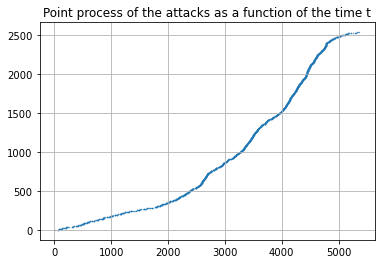

In [1]:
## Importing the data

import pandas as pd
from datetime import datetime
from scipy.optimize import minimize,root_scalar,LinearConstraint
import numpy as np
import matplotlib.pylab as plt
from scipy.stats import kstest, chisquare

df=pd.read_csv("PRC.csv",sep=';')
dff=df.loc[df['Type of breach']=="HACK",'Date Made Public']
dff=dff.apply(lambda x:datetime.strptime(x,'%m/%d/%Y'))
debut=min(dff)
dff=dff-debut
dff=dff.apply(lambda x:x.days).sort_values()
l=np.asarray(dff)[1:]
plt.scatter(l,1+np.arange(len(l)),s=0.1)
plt.grid()
plt.title("Point process of the attacks as a function of the time t")
plt.show()

In [2]:
## Visualization of the data we will work on

print('dff',dff)
print('\nl',l, 'which has length', len(l))

dff 1577       0
1578       8
1584      57
1586      60
1590      65
        ... 
6552    5303
6549    5320
6548    5321
6544    5341
6543    5364
Name: Date Made Public, Length: 2533, dtype: int64

l [   8   57   60 ... 5321 5341 5364] which has length 2532


---

# Question 2

We start by implementing the negative loglikelihood function, that we will minimize using ``` scipy.optimize.minimize()```
The likelihood is defined for any time t that's why we wanted at first, a global (uniform) value of $\alpha$, $\beta$ and $\gamma$ but due to the complexity and the potential impossibility of computation, we chose to set ```t=l[-1]```.  By choosing this value, we look at the likelihood that the entire path is a Hawkes Process.

In [3]:
t = l[-1]

def loglikelihood(x):
    ll = np.array(l)
    alpha = x[0]
    beta = x[1]
    gamma = x[2]
    n = len(ll)
    s = 0
    t = ll[-1]
    
    for i in range(n):
        if ll[i] <= t :
            s += np.log( alpha + beta * np.sum( np.exp( -gamma*(ll[i] - ll[0:i]) ) )) 
            s -= beta/gamma * (1-np.exp(-gamma*(t-ll[i])))
    s += (1-alpha)*t
    
    return -s

In [12]:
print(loglikelihood([1,1,1]))
print(loglikelihood([0.1,0.1,10]))
print(loglikelihood([0.4, 1, 1]))

1036.39455232292
136.432757858659
-909.804402833553


In [14]:
n = len(l)
A = np.zeros(n)
B = np.zeros(n)
def AandB(x):
    alpha = x[0]
    beta = x[1]
    gamma = x[2]
    A[0] = 0
    B[0] = 0
    for i in range(1,n):
        A[i] =  np.exp(-gamma*(l[i] - l[i-1]))*(1+A[i-1])
        B[i] =  np.exp(gamma*(l[i] - l[i-1]))*(1+B[i-1])
    

In [24]:
def der_beta(x):
    ll = np.array(l)
    alpha = x[0]
    beta = x[1]
    gamma = x[2]
    n = len(ll)
    s = 0
    t = ll[-1]
    AandB(x)
    for i in range(n):
        s = s + (1/gamma)*(np.exp(-gamma*(t-ll[i])) - 1) + (A[i]/(alpha + beta*A[i]))
    return s

In [23]:
def der_gamma(x):
    ll = np.array(l)
    alpha = x[0]
    beta = x[1]
    gamma = x[2]
    n = len(ll)
    s = 0
    t = ll[-1]
    AandB(x)
    for i in range(n):
        s = s - beta*((1/gamma)*(t-ll[i])*np.exp(-gamma*(t-ll[i]))) - (beta*B[i]/(alpha + beta*A[i]))
    return s

In [22]:
def der_alpha(x):
    ll = np.array(l)
    alpha = x[0]
    beta = x[1]
    gamma = x[2]
    n = len(ll)
    s = 0
    t = ll[-1]
    AandB(x)
    for i in range(n):
        s = s + (1/(alpha + beta*A[i]))
    s = s - t
    return s

In [21]:
print(der_alpha([1,1,1]))
print(der_alpha([0.1,0.1,10]))
print(der_alpha([0.4, 1, 1]))

-3788.8518447781757
14347.337184274642
-2348.465620855125


C:\Users\ASPIRE 5\AppData\Local\Temp\ipykernel_8656\3241094419.py:12: RuntimeWarning: overflow encountered in double_scalars
  B[i] =  np.exp(gamma*(l[i] - l[i-1]))*(1+B[i-1])


In [26]:
print(der_gamma([1,1,1]))
print(der_gamma([0.1,0.1,10]))
print(der_gamma([0.4, 1, 1]))

-inf
-inf
-inf


C:\Users\ASPIRE 5\AppData\Local\Temp\ipykernel_8656\3241094419.py:12: RuntimeWarning: overflow encountered in double_scalars
  B[i] =  np.exp(gamma*(l[i] - l[i-1]))*(1+B[i-1])


In [25]:
print(der_beta([1,1,1]))
print(der_beta([0.1,0.1,10]))
print(der_beta([0.4, 1, 1]))

-1574.1481552217213
5355.562815725219
-1205.2137516578468


C:\Users\ASPIRE 5\AppData\Local\Temp\ipykernel_8656\3241094419.py:12: RuntimeWarning: overflow encountered in double_scalars
  B[i] =  np.exp(gamma*(l[i] - l[i-1]))*(1+B[i-1])


## explain the constraint and why we took alpha, beta, gamma >=0 , and beta/gamma<1 (LATEX)

we assume that the conditional intensity has the following form:
$$\dot{y}(N,t) = \alpha + \beta\int_0^{t-}e^{-\gamma(t-s)}dN(s)$$
where:

$\alpha$, $\beta$ and $\gamma$ are positive real numbers and $\frac{\beta}{\gamma}<1$. 

The constants $\beta$ and $\gamma$ have the following interpretation: each arrival in the system instantaneously increases the arrival intensity by $\beta$, then over the time this arrival's influence decays at rate $\gamma$

In [31]:
bounds = [(0, None), (0, None), (0, None)]

beta_over_gamma_constraint = [LinearConstraint([[0, 1, -1]], [-np.inf], [-1e-09])]

initial_x = np.array([1,0.0008,0.007])

minimal = minimize(loglikelihood, initial_x, bounds = bounds, constraints=beta_over_gamma_constraint)

print(minimal)
print()
print('Initial [alpha, beta, gamma] =', initial_x)
print('alpha = ', minimal.x[0])
print('beta = ',  minimal.x[1] )
print('gamma = ',  minimal.x[2]) 
print('and ratio beta/gamma =',  minimal.x[1]/ minimal.x[2], '\n')

## """ method = 'Default' """

     fun: -14046.301224687435
     jac: array([-0.00927734,  0.00048828,  0.        ])
 message: 'Optimization terminated successfully'
    nfev: 151
     nit: 29
    njev: 29
  status: 0
 success: True
       x: array([2.94369742e-01, 3.37179938e+05, 2.77368336e+06])

Initial [alpha, beta, gamma] = [1.e+00 8.e-04 7.e-03]
alpha =  0.2943697415517929
beta =  337179.93751027994
gamma =  2773683.355208832
and ratio beta/gamma = 0.12156396182609443 



**Warning :** The next cell might take some time to execute

Let's try different initial values and see how the results behave

In [32]:
initial_x = [1,1,1]
minimal = minimize(loglikelihood, initial_x, bounds = bounds, constraints=constraints)
alpha_star, beta_star, gamma_star = minimal.x[0], minimal.x[1], minimal.x[2]
print('Initial [alpha, beta, gamma] =', initial_x)
print('alpha = ', alpha_star)
print('beta = ', beta_star )
print('gamma = ', gamma_star) 
print('and ratio beta/gamma =', beta_star/gamma_star)
print('Success of optimization', minimal.success, '\n')

initial_x = [0.1,0.1,10]
minimal = minimize(loglikelihood, initial_x,  bounds = bounds, constraints=constraints)
alpha_star, beta_star, gamma_star = minimal.x[0], minimal.x[1], minimal.x[2]
print('Initial [alpha, beta, gamma] =', initial_x)
print('alpha = ', alpha_star)
print('beta = ', beta_star )
print('gamma = ', gamma_star) 
print('and ratio beta/gamma =', beta_star/gamma_star)
print('Success of optimization', minimal.success, '\n')

initial_x = [0.4, 1, 1]
minimal = minimize(loglikelihood, initial_x, bounds = bounds, constraints=constraints)
alpha_star, beta_star, gamma_star = minimal.x[0], minimal.x[1], minimal.x[2]
print('Initial [alpha, beta, gamma] =', initial_x)
print('alpha = ', alpha_star)
print('beta = ', beta_star )
print('gamma = ', gamma_star) 
print('and ratio beta/gamma =', beta_star/gamma_star)
print('Success of optimization', minimal.success, '\n')

Initial [alpha, beta, gamma] = [1, 1, 1]
alpha =  0.2944753582360483
beta =  30417.45171836557
gamma =  35173.189107448605
and ratio beta/gamma = 0.8647908389951505
Success of optimization True 

Initial [alpha, beta, gamma] = [1, 1, 2]
alpha =  0.29449667589208756
beta =  36513.71305136755
gamma =  90977.76556905148
and ratio beta/gamma = 0.4013476570124587
Success of optimization True 

Initial [alpha, beta, gamma] = [0.4, 1, 1]
alpha =  0.2950585846738998
beta =  162949.3764883204
gamma =  243813.73208304038
and ratio beta/gamma = 0.6683355161998077
Success of optimization True 



By looking at these results, we can observe that the value of $\alpha$ is rather constant. However, we see that the values of $\beta$ and $\gamma$ don't seem to be bounded and change a lot when changing the initial values.


Now we would like to test the stability of the results by slightly changing the initial values.

In [38]:
## Stability Test: 

initial_x = [1,1,1]
minimal = minimize(loglikelihood, initial_x, bounds = bounds, constraints=constraints)
alpha_star, beta_star, gamma_star = minimal.x[0], minimal.x[1], minimal.x[2]
print('Initial [alpha, beta, gamma] =', initial_x)
print('alpha = ', alpha_star)
print('beta = ', beta_star )
print('gamma = ', gamma_star) 
print('The value of loglikelihood', minimal.fun)
print('Success of optimization', minimal.success, '\n')


initial_x = [1,1,1.1]
minimal = minimize(loglikelihood, initial_x,  bounds = bounds, constraints=constraints)
alpha_star, beta_star, gamma_star = minimal.x[0], minimal.x[1], minimal.x[2]
print('Initial [alpha, beta, gamma] =', initial_x)
print('alpha = ', alpha_star)
print('beta = ', beta_star )
print('gamma = ', gamma_star) 
print('The value of loglikelihood', minimal.fun)
print('Success of optimization', minimal.success, '\n')


initial_x = [1,1,2]
minimal = minimize(loglikelihood, initial_x,  bounds = bounds, constraints=constraints)
alpha_star, beta_star, gamma_star = minimal.x[0], minimal.x[1], minimal.x[2]
print('Initial [alpha, beta, gamma] =', initial_x)
print('alpha = ', alpha_star)
print('beta = ', beta_star )
print('gamma = ', gamma_star) 
print('The value of loglikelihood', minimal.fun)
print('Success of optimization', minimal.success, '\n')

Initial [alpha, beta, gamma] = [1, 1, 1]
alpha =  0.2944753582360483
beta =  30417.45171836557
gamma =  35173.189107448605
The value of loglikelihood -9872.66323936915
Success of optimization True 

Initial [alpha, beta, gamma] = [1, 1, 1.1]
alpha =  0.29437129764459175
beta =  24521.4489146189
gamma =  33144.01136534746
The value of loglikelihood -9983.560269689442
Success of optimization True 

Initial [alpha, beta, gamma] = [1, 1, 2]
alpha =  0.29449667589208756
beta =  36513.71305136755
gamma =  90977.76556905148
The value of loglikelihood -11219.722545783676
Success of optimization True 



* First, by slightly (1 and 1.1) changing the initial value of $\gamma$ while mainting the others constant, we can see that the value of $\alpha$ and $\gamma$ is almost the same. But, the value of $\beta$ decreases considerably.
* Secondly, we changed the value of  $\gamma$ more so (1 to 2),  $\alpha$ is still constant but  $\beta$ increases slightly and  $\gamma$ explodes.

$\rightarrow$ Though  $\alpha$ is stable and  $\beta$ doesn't seem to change a lot, we can see that changing the initial value of  $\gamma$ really impacts its behaviour and that the loglikelihood seems to have a lot of different local minimals.

In [43]:
initial_x = [1,1e+29,1e+30]
minimal = minimize(loglikelihood, initial_x,  bounds = bounds, constraints=constraints)
alpha_star, beta_star, gamma_star = minimal.x[0], minimal.x[1], minimal.x[2]
print('Initial [alpha, beta, gamma] =', initial_x)
print('alpha = ', alpha_star)
print('beta = ', beta_star )
print('gamma = ', gamma_star) 
print('The value of loglikelihood', minimal.fun)
print('Success of optimization', minimal.success, '\n')

Initial [alpha, beta, gamma] = [1, 1e+29, 1e+30]
alpha =  0.2943783057492528
beta =  1e+29
gamma =  1e+30
The value of loglikelihood -65607.28467576455
Success of optimization True 



We can see that by choosing some very bad initial values for $\beta$ and $\gamma$, we have some unusable results, even though we find better values for the minimum of the -loglikelihood.  

#### Conclusion:

We ran several test (and even more than what is shown) and we find that the obtainted values of the parameters $\alpha$, $\beta$, $\gamma$ are all stricly positive and the ratio $\frac{\beta}{\gamma}$ is always smaller than $1$.

---

# Question 3

In this question, we decided to choose some initial values of $\alpha$, $\beta$ and $\gamma$ that we found arbitrarly but that still allowed for values of $\beta$ and $\gamma$ that do not explode.

In [61]:
initial_x = np.array([1,0.0001,0.001])

minimal = minimize(loglikelihood, initial_x, bounds = bounds, constraints=constraints)
print(initial_x)
print(minimal)
print()
alpha, beta, gamma = minimal.x[0], minimal.x[1], minimal.x[2]
print('Initial [alpha, beta, gamma] =', initial_x ,'alpha = ', alpha, 'beta = ', beta ,'gamma = ', gamma, 'and ratio beta/gamma =', beta/gamma)

[1.e+00 1.e-04 1.e-03]
     fun: -16238.497329231197
     jac: array([0.02490234, 0.        , 0.        ])
 message: 'Optimization terminated successfully'
    nfev: 153
     nit: 33
    njev: 33
  status: 0
 success: True
       x: array([2.94370554e-01, 2.93078050e+06, 4.20854296e+07])

Initial [alpha, beta, gamma] = [1.e+00 1.e-04 1.e-03] alpha =  0.29437055437953136 beta =  2930780.501722357 gamma =  42085429.56663883 and ratio beta/gamma = 0.06963884013781316


Now we plot! :)

## LATEK FOR Y

[   2.35495793   16.90063923   17.90531242 ... 1873.77665426 1879.78561305
 1886.67768107]


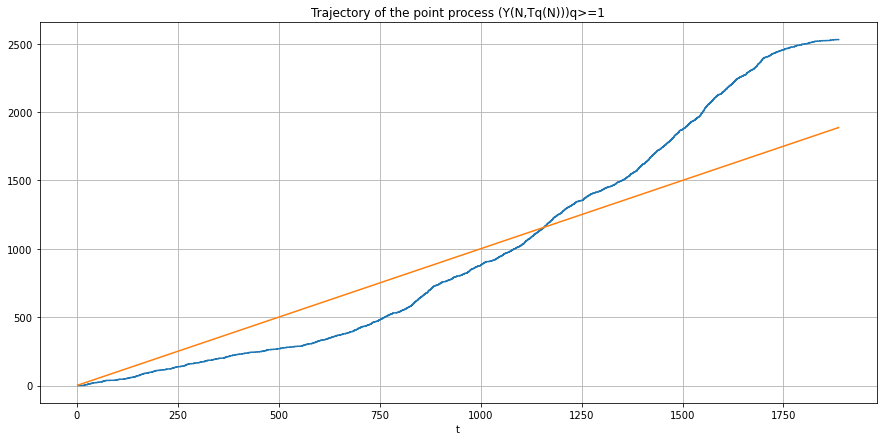

In [60]:
def NewProcessY(l, alpha, beta, gamma):
    L = []
    n= len (l)
    y = lambda l,i  : alpha*l[i] + beta/gamma * np.sum(1 - np.exp(-gamma*(l[i]-l[0:i]))) 
    for i in range (n):
        new_time= y(l,i)
        L.append(new_time)
    
    return np.array(L)

L = NewProcessY(l,alpha, beta, gamma)
print(L)

pointprocess = [0] + list(range(len(L)-1))

plt.figure(figsize = (15,7))
plt.step(L, pointprocess)
plt.plot(L,L)
plt.title("Trajectory of the point process (Y(N,Tq(N)))q>=1")
plt.xlabel('t')
plt.grid()
plt.show()

Let's define the list of inter-arrival times as follows in order to compare these samples to $\mathcal{Exp}(1)$ and so check the Poisson Hypothesis

In [74]:
inter_arrival = np.array([L[i+1]-L[i] for i in range(len(L)-1)])
print(inter_arrival)

print('Estimation of lambda using the mean : ', 1/np.mean(inter_arrival))
print('Estimation of lambda using the standard variation : ', 1/np.sqrt(np.var(inter_arrival)))

[14.5456813   1.00467319  1.59341267 ...  0.4159337   6.00895879
  6.89206802]
Estimation of lambda using the mean :  1.3431881752142005
Estimation of lambda using the standard variation :  0.9042228885890146


These values are not too far from 1, but it's not enough to conclude, let's plot a histogramm and compare it to the density of $\mathcal{Exp}(1)$ 

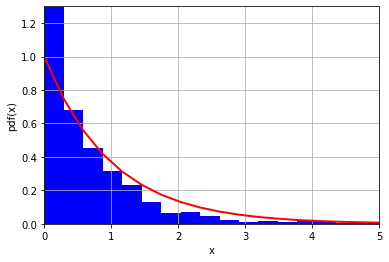

In [63]:
f= lambda x: np.exp(-x)

n, bins, patches=plt.hist(inter_arrival, bins=50, density=True, color = 'b')
plt.plot(bins, f(bins), linewidth=2, color='red')
plt.axis([0, 5,0,1.3])
plt.xlabel('x')
plt.ylabel('pdf(x)')
plt.grid()
plt.show()

The histogram looks good: we can see that the bins seem to follow a distribution that is rathern close to the exponential one. Therefore, we can conclude that the hawkes process can actually be a good modelization of the database.

# Final conclusion :  